<a href="https://colab.research.google.com/github/David-Carballo/2023w-project-pose/blob/main/Full_dataset_Mobilenet_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.utils import list_files
from torchvision.datasets.folder import pil_loader
from torchvision.utils import make_grid
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from PIL import Image
import os
import zipfile
import albumentations as A
import cv2
import random
from torchvision.transforms import ToPILImage

device = 'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# nombre del archivo zip
zip_file = '/content/drive/MyDrive/Postgrau AI/DATASET.zip'
# ruta donde se descomprimirá el archivo
extract_to = '/content/descomprimido'
# descomprimir el archivo
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
train_dir = '/content/descomprimido/TRAIN'
val_dir = '/content/descomprimido/VALIDATION'
test_dir = '/content/descomprimido/TEST'

In [ ]:
class YogaDataset(Dataset):
    def __init__(self, data_dir, transforms = False):
        self.data_dir = data_dir
        self.images = []
        self.labels = []
        self.labels_num = []
        self.eps = 0.75
        self.transforms = transforms

        label_map = {}
        label_counter = 0

        for subdir in os.listdir(data_dir):
            subdir_path = os.path.join(data_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    file_path = os.path.join(subdir_path, file)
                    if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                        self.images.append(file_path)
                        label = subdir
                        if label not in label_map:
                            label_map[label] = label_counter
                            label_counter += 1
                        # Convert label to numerical ID and store it in self.labels_num
                        label_num = label_map[label]
                        self.labels.append(label)
                        self.labels_num.append(label_num)

    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path).convert('RGB') #CHECK
        if self.transforms == True:
            if random.random() < self.eps:
                img = self.data_augmentation(img=np.array(img))['image']
        tensor_img = transforms.ToTensor()(img)
        tensor_img = self.image_transform(tensor_img)
        label_num = self.labels_num[index]
        return tensor_img, label_num
    
    def image_transform(self, tensor):
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        resize = transforms.Resize(224)
        #Check if image size ratio is 1:1
        if tensor.shape[1] != tensor.shape[2]:
            #Calculate difference between X and Y axis
            diff = tensor.shape[1] - tensor.shape[2]
            #Check what dimension needs to be padded either the X (dimension 1 of the tensor, right), or the Y (dimension 3, bottom)
            if diff > 0:     
                tensor = F.pad(input=tensor, pad=(0, abs(diff), 0, 0), mode='constant', value=0) #pad(left, right, top, bottom)
            else:
                tensor = F.pad(input=tensor, pad=(0, 0, 0, abs(diff)), mode='constant', value=0)
        tensor = resize(tensor)
        tensor = tensor.reshape(3, 224, 224)
        return tensor

    def data_augmentation(self, img):
        da_transforms = A.Compose([
        A.HorizontalFlip(p = 0.5),
        A.GaussianBlur(p = 0.5),
        A.HueSaturationValue(p = 0.5),
        A.ColorJitter(p = 0.5),
        ])

        # apply data augmentation transforms
        img = da_transforms(image=np.array(img))['image']
        
        return {'image': img}


    def __len__(self):
        return len(self.images)

In [ ]:
#47 classes

In [ ]:
train_dataset = YogaDataset(train_dir, transforms = True)
test_dataset = YogaDataset(test_dir)
val_dataset = YogaDataset(val_dir)
print('Number of images', len(val_dataset))
print(train_dataset[0])

Number of images 547
(tensor([[[0.8353, 0.8353, 0.8317,  ..., 0.9533, 0.9569, 0.9569],
         [0.8390, 0.8355, 0.8351,  ..., 0.9533, 0.9569, 0.9569],
         [0.8464, 0.8460, 0.8428,  ..., 0.9533, 0.9569, 0.9569],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8157, 0.8157, 0.8157,  ..., 0.9176, 0.9179, 0.9216],
         [0.8194, 0.8159, 0.8157,  ..., 0.9176, 0.9179, 0.9216],
         [0.8268, 0.8264, 0.8231,  ..., 0.9176, 0.9179, 0.9216],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.7922, 0.7922, 0.7922,  ..., 0.8824, 0.8826, 0.8863],
         [0.7959, 0.7924, 0.7922,  ..., 0.8824, 0.8826, 0.8863],
         [0.7996, 0.7993, 0.7993,  .

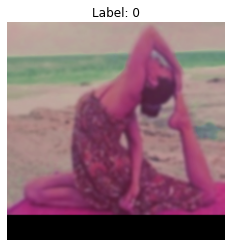

In [ ]:
image, label = train_dataset[0]

# convert the tensor image to a PIL Image
to_pil = ToPILImage()
pil_image = to_pil(image)

# plot the image and show its corresponding label
plt.imshow(pil_image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [ ]:
#for image, label in train_dataset:
  #shape = torchvision.transforms.functional.get_image_size(image)
  #print (shape)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print(len(train_loader))

51


In [ ]:
#model = torchvision.models.mobilenet_v3_small(weights = 'DEFAULT')
model = torchvision.models.efficientnet_b3(weights='DEFAULT')
#Substitution of the model's last layer so it predicts between the 47 classes of the Dataset instead of the 1000 of Imagenet
#in_features = model.classifier[0].in_features
#model.classifier[0] = nn.Linear(in_features, 50)
#model.classifier[-1] = nn.Linear(50, 47)
#model.classifier[2] = nn.Dropout(0.5, inplace = True)
model.classifier = nn.Sequential(
    nn.BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Linear(in_features=1536, out_features=50, bias=True),
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=50, out_features=47, bias=True),
    nn.LogSoftmax(dim = -1)  
)

#Dropout 0.3/0.4
#Freeze all the layers except the final Linear

for param in model.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
criterion = nn.NLLLoss()
#optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 0.01)
optimizer = optim.AdamW(
    [
        {"params": model.features.parameters(), "lr": 1e-5},
        {"params": model.classifier.parameters(), "lr": 1e-4},
    ],weight_decay = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
def train(model, train_loader, criterion, optimizer, device, num_epochs):
  
    model.train()
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Update train loss and accuracy once per epoch
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        
        # Run validation loop once per epoch and update val accuracy
        val_acc = validate(model, val_loader, criterion, device)
        val_acc_list.append(val_acc)

        print('[Epoch %d] Train Loss: %.3f, Train Acc: %.3f, Val Acc: %.3f' %
              (epoch + 1, train_loss, train_acc, val_acc))

    # Plot train and val accuracy once training is finished
    plt.plot(train_acc_list)
    plt.plot(val_acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Validation'])
    plt.show()

    print('Finished Training')




In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Print validation statistics
    print('Validation Loss: %.3f, Accuracy: %.3f' %
          (running_loss / len(val_loader), accuracy))

    return accuracy

In [ ]:
num_epochs = 20
train(model, train_loader, criterion, optimizer, device, num_epochs)

Validation Loss: 3.730, Accuracy: 6.216
[Epoch 1] Train Loss: 3.877, Train Acc: 3.196, Val Acc: 6.216
Validation Loss: 3.450, Accuracy: 17.733
[Epoch 2] Train Loss: 3.963, Train Acc: 17.701, Val Acc: 17.733
Validation Loss: 3.031, Accuracy: 27.422
[Epoch 3] Train Loss: 3.043, Train Acc: 32.329, Val Acc: 27.422
Validation Loss: 2.436, Accuracy: 40.037
[Epoch 4] Train Loss: 2.393, Train Acc: 48.740, Val Acc: 40.037
Validation Loss: 1.931, Accuracy: 49.177
[Epoch 5] Train Loss: 1.647, Train Acc: 65.396, Val Acc: 49.177
Validation Loss: 1.676, Accuracy: 56.490
[Epoch 6] Train Loss: 1.111, Train Acc: 73.940, Val Acc: 56.490
Validation Loss: 1.434, Accuracy: 58.501
[Epoch 7] Train Loss: 0.792, Train Acc: 80.148, Val Acc: 58.501
Validation Loss: 1.381, Accuracy: 60.695
[Epoch 8] Train Loss: 0.580, Train Acc: 85.986, Val Acc: 60.695
Validation Loss: 1.307, Accuracy: 61.426
[Epoch 9] Train Loss: 0.420, Train Acc: 89.859, Val Acc: 61.426
Validation Loss: 1.312, Accuracy: 59.781
[Epoch 10] Train 

KeyboardInterrupt: ignored

In [ ]:
def test(model, test_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print test statistics
    print('Test Loss: %.3f, Accuracy: %.3f' %
          (running_loss / len(test_loader), 100 * correct / total))

    return 100 * correct / total

In [ ]:
test(model, test_loader, criterion, device)